In [1]:
# pip install --upgrade tensorflow
%matplotlib inline
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# !pip install tensorflow
# !pip install keras_tuner

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

lw = 1 # line weight for plt
SHUFFLE_BUFFER = 500
BATCH_SIZE = 32 # Model batch size
EPOCHS = 100 # Model number of epoch 
MODELS_RESULTS={} # store for all model result for both balanced and resampled datasets
n_classes=10
num_columns = 42  # Number of columns in df
regularizers=tf.keras.regularizers.l2(0.001)
print(tf.__version__)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

2.7.0


In [3]:
# importing the train and test data dataset from file
train_val_csv = pd.read_csv('./data/UNSW_NB15_training-set.csv')
test_csv = pd.read_csv('./data/UNSW_NB15_testing-set.csv')

In [4]:
train_val=train_val_csv.drop(columns=['id','label'])
test=test_csv.drop(columns=['id','label'])

In [5]:
# Split the data into train and test with 80 train / 20 test
train,val = train_test_split(train_val, test_size=0.2, random_state = 1)

In [6]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65865 training examples
16467 validation examples
175341 test examples


In [7]:
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
print(CLASSES)
# # five metrics used for evaluation process
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [8]:
def plot_chart(history,name):
    plt.figure(figsize=(10, 10))
    names =['loss','accuracy']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

In [9]:
def group_by_data_type(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result

In [10]:
# convert dataprame to tensore datasets
def dataframe_to_dataset_multi_feature(dataframe):
    attack_cat=dataframe.pop('attack_cat')
    x_num=tf.convert_to_tensor(dataframe[number_col])
    x_string=tf.convert_to_tensor(dataframe[string_category_col])
    x_int=tf.convert_to_tensor(dataframe[int_category_col])
    attack_cat = attack_cat.map(CLASSES.index)
    y=tf.keras.utils.to_categorical(attack_cat, num_classes=10)
    return [x_num,x_string,x_int],y

In [11]:
train_df = train.copy();
val_df = val.copy();
test_df = test.copy();

In [12]:
# seperate the structured data into individal type
data_types = group_by_data_type(train_df) # return result from
number_col=data_types['number_col']
string_category_col=data_types['string_category_col']
int_category_col=data_types['int_category_col']

In [13]:
print('numbers column', number_col)
print('_________________________________________________')
print('string column',string_category_col)
print('_________________________________________________')
print('integer column',int_category_col)

numbers column ['dur', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat']
_________________________________________________
string column ['proto', 'service', 'state']
_________________________________________________
integer column ['spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'swin', 'stcpb', 'dtcpb', 'dwin', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


In [14]:
# ensure all preprosesing  layer adapt to the structure of the dataset 
dataframe = train_df.copy()
_ds= dataframe_to_dataset_multi_feature(dataframe)
X,y=_ds
input_num_shape = X[0].shape[1:]
input_string_shape = X[1].shape[1:]
input_int_shape = X[2].shape[1:]

adapt_input_num = X[0]
adapt_input_string = X[1]
adapt_input_int = X[2]
adapt_input_string

<tf.Tensor: shape=(65865, 3), dtype=string, numpy=
array([[b'udp', b'dns', b'INT'],
       [b'udp', b'dns', b'INT'],
       [b'tcp', b'-', b'FIN'],
       ...,
       [b'unas', b'-', b'INT'],
       [b'tcp', b'-', b'FIN'],
       [b'tcp', b'-', b'FIN']], dtype=object)>

In [15]:
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.experimental.preprocessing.Normalization()
normalizer.adapt(adapt_input_num)

In [16]:
# Create a Intlookup layer and set its internal state using the training data
string_lookup = layers.StringLookup(output_mode="multi_hot")
string_lookup.adapt(adapt_input_string)
string_vocabulary=string_lookup.get_vocabulary()

In [17]:
# Create a Normalization layer and set its internal state using the training data
int_lookup = layers.IntegerLookup( output_mode="multi_hot")
int_lookup.adapt(adapt_input_int)

In [18]:
# # Load some data
def build_eaily_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
   # include the normalization layer
    x1 = normalizer(input_num)
   # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
   # include the int_lookup layer
    x2 = int_lookup(input_int)
   # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
   # include the int_lookup layer
    x3 = string_lookup(input_string)
    concat = tf.keras.layers.Concatenate(axis=1)([x1,x2,x3])
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units_1,activation='relu',kernel_regularizer=regularizers)(concat)
    x = layers.Dropout(0.5)(x)
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_2,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_3,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    print('MODAL-SUMMARY')
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [19]:
# # Load some data
def build_late_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
    # include the normalization layer
    x1 = normalizer(input_num)
    # dence layers for numeric data
    hp_units_num_1 = hp.Int('units_num_1', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_1,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_2 = hp.Int('units_num_2', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_2,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    hp_units_num_3 = hp.Int('units_num_3', min_value=32, max_value=512, step=32)
    x1 = layers.Dense(units=hp_units_num_3,activation='relu',kernel_regularizer=regularizers)(x1)
    x1 = layers.Dropout(0.5)(x1)
    
    output_num = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x1)
    model_1=keras.models.Model(inputs=input_num, outputs=output_num)
    print('SUBMODAL-INTEGER-NUMERIC')
    model_1.summary()
    y1= model_1(input_num)
    
  # Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
  # include the int_lookup layer
    x2 = int_lookup(input_int)
  # dence layers for integer data
    hp_units_int_1 = hp.Int('units_int_1', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_1,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_2 = hp.Int('units_int_2', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_2,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)
    
    hp_units_int_3 = hp.Int('units_int_3', min_value=32, max_value=512, step=32)
    x2 = layers.Dense(units=hp_units_int_3,activation='relu',kernel_regularizer=regularizers)(x2)
    x2 = layers.Dropout(0.5)(x2)

    output_int = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x2)
    model_2=keras.models.Model(inputs=input_int, outputs=output_int)
    print('SUBMODAL-INTEGER-SUMMARY')
    model_2.summary()
    y2= model_2(input_int)
    
  # Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
  # include the int_lookup layer
    x3 = string_lookup(input_string)
  # dence layers for string data
    hp_units_string_1 = hp.Int('units_string_1', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_1,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    hp_units_string_2 = hp.Int('units_string_2', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_2,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    
    hp_units_string_3 = hp.Int('units_string_3', min_value=32, max_value=512, step=32)
    x3 = layers.Dense(units=hp_units_string_3,activation='relu',kernel_regularizer=regularizers)(x3)
    x3 = layers.Dropout(0.5)(x3)
    
    output_string = layers.Dense(128,activation='relu',kernel_regularizer=regularizers)(x3)
    model_3=keras.models.Model(inputs=input_string, outputs=output_string)
    print('SUBMODAL-STRING-SUMMARY')
    model_3.summary()
    y3= model_3(input_string)
    
    avg = tf.keras.layers.Average()([y1,y2,y3])
    output = layers.Dense(n_classes, activation="softmax")(avg)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [20]:
def build_model(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Input layer for numeric data
    input_num = keras.Input(shape=input_num_shape, name='numeric_inputs')
# Input layer for integer cartegory data
    input_int = keras.Input(shape=input_int_shape, name='cartegory_integer_inputs')
# Input layer for string cartegory data
    input_string = keras.Input(shape=input_string_shape, name='cartegory_string_inputs',dtype='string')
# all inputs in an array
    inputs=[input_num,input_string,input_int]
  # NN models based on single and multi model defined above
  # Model #1: NN single  model
    model_1 = build_eaily_model(hp)
  # Model #2: NN multi model
    model_2 = build_late_model(hp)
  # DF models
#   Model #3: DF model
#   model_3 = model_lstm()

  # predictions from model
    y1 = model_1(inputs)
    y2 = model_2(inputs)
#   y3 = model_3(inputs)

    y = layers.average([y1, y2])
    hp_units_y = hp.Int('units_y', min_value=32, max_value=512, step=32)
    y = layers.Dense(units=hp_units_y,activation='relu',kernel_regularizer=regularizers)(y)
    y = layers.Dropout(0.5)(y)
    output = layers.Dense(n_classes, activation="softmax")(y)
    model = keras.Model(inputs=[input_num,input_string,input_int], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [21]:
# model fix, compyling and visualisation 
# LATE-ENSEMBLE
df = train_df.copy()
X_train,y_train= dataframe_to_dataset_multi_feature(df)
df = val_df.copy()
X_val,y_val= dataframe_to_dataset_multi_feature(df)
df = test_df.copy()
X_test,y_test= dataframe_to_dataset_multi_feature(df)

In [23]:
print('LATE-ENSEMBLE')
name='LATE-ENSEMBLE'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
MODELS_RESULTS[name]={}
project_name='HYPERPARAM_'+name
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
print('----')
#     early stoppping if val_loss is behaving poorly
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     hyperparameter search based on 50 epochs
tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print('----')
history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')

Trial 30 Complete [02h 37m 33s]
val_accuracy: 0.825408399105072

Best val_accuracy So Far: 0.8261978626251221
Total elapsed time: 15h 04m 44s
INFO:tensorflow:Oracle triggered exit
MODAL-SUMMARY
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 11)]         0           []                               
                                                                                                  
 cartegory_integer_inputs (Inpu  [(None, 28)]        0           []                               
 tLayer)                                                                                          
                                                                                                  
 cartegory_string_inputs (Input  [(None, 3)]         0           []                             

----
Epoch 1/100
2059/2059 [==============================] - 896s 432ms/step - loss: 1.6443 - accuracy: 0.6867 - precision: 0.8851 - recall: 0.5350 - auc: 0.9405 - prc: 0.7646 - val_loss: 0.7851 - val_accuracy: 0.7812 - val_precision: 0.9140 - val_recall: 0.6480 - val_auc: 0.9722 - val_prc: 0.8719
Epoch 2/100
2059/2059 [==============================] - 888s 431ms/step - loss: 0.7437 - accuracy: 0.7823 - precision: 0.9059 - recall: 0.6704 - auc: 0.9743 - prc: 0.8764 - val_loss: 0.6869 - val_accuracy: 0.7887 - val_precision: 0.9153 - val_recall: 0.7004 - val_auc: 0.9791 - val_prc: 0.8930
Epoch 3/100
2059/2059 [==============================] - 889s 432ms/step - loss: 0.6796 - accuracy: 0.7991 - precision: 0.8946 - recall: 0.7160 - auc: 0.9783 - prc: 0.8929 - val_loss: 0.6364 - val_accuracy: 0.8209 - val_precision: 0.8954 - val_recall: 0.7272 - val_auc: 0.9808 - val_prc: 0.9038
Epoch 4/100
2059/2059 [==============================] - 891s 433ms/step - loss: 0.6371 - accuracy: 0.8210 - p

Epoch 29/100
2059/2059 [==============================] - 1036s 503ms/step - loss: 0.4952 - accuracy: 0.8445 - precision: 0.9183 - recall: 0.7968 - auc: 0.9888 - prc: 0.9396 - val_loss: 0.5112 - val_accuracy: 0.8371 - val_precision: 0.9140 - val_recall: 0.7865 - val_auc: 0.9875 - val_prc: 0.9350
Epoch 30/100
2059/2059 [==============================] - 994s 483ms/step - loss: 0.4952 - accuracy: 0.8444 - precision: 0.9160 - recall: 0.7970 - auc: 0.9889 - prc: 0.9394 - val_loss: 0.5141 - val_accuracy: 0.8378 - val_precision: 0.9105 - val_recall: 0.7899 - val_auc: 0.9875 - val_prc: 0.9345
Epoch 31/100
2059/2059 [==============================] - 920s 447ms/step - loss: 0.4938 - accuracy: 0.8442 - precision: 0.9165 - recall: 0.7972 - auc: 0.9889 - prc: 0.9398 - val_loss: 0.5146 - val_accuracy: 0.8361 - val_precision: 0.9153 - val_recall: 0.7861 - val_auc: 0.9874 - val_prc: 0.9342
Epoch 32/100
2059/2059 [==============================] - 946s 459ms/step - loss: 0.4912 - accuracy: 0.8464 - p

Epoch 57/100
2059/2059 [==============================] - 1086s 527ms/step - loss: 0.4661 - accuracy: 0.8513 - precision: 0.9257 - recall: 0.8043 - auc: 0.9903 - prc: 0.9458 - val_loss: 0.5084 - val_accuracy: 0.8404 - val_precision: 0.9118 - val_recall: 0.7959 - val_auc: 0.9871 - val_prc: 0.9362
Epoch 58/100
2059/2059 [==============================] - 1125s 546ms/step - loss: 0.4663 - accuracy: 0.8514 - precision: 0.9258 - recall: 0.8046 - auc: 0.9903 - prc: 0.9458 - val_loss: 0.5068 - val_accuracy: 0.8416 - val_precision: 0.9135 - val_recall: 0.7955 - val_auc: 0.9874 - val_prc: 0.9364
Epoch 59/100
2059/2059 [==============================] - 1062s 516ms/step - loss: 0.4642 - accuracy: 0.8529 - precision: 0.9265 - recall: 0.8051 - auc: 0.9905 - prc: 0.9461 - val_loss: 0.5034 - val_accuracy: 0.8409 - val_precision: 0.9174 - val_recall: 0.7912 - val_auc: 0.9879 - val_prc: 0.9368
Epoch 60/100
2059/2059 [==============================] - 940s 456ms/step - loss: 0.4639 - accuracy: 0.8526 -

Epoch 85/100
2059/2059 [==============================] - 638s 310ms/step - loss: 0.4529 - accuracy: 0.8548 - precision: 0.9290 - recall: 0.8071 - auc: 0.9909 - prc: 0.9488 - val_loss: 0.5010 - val_accuracy: 0.8415 - val_precision: 0.9182 - val_recall: 0.7915 - val_auc: 0.9879 - val_prc: 0.9377
Epoch 86/100
2059/2059 [==============================] - 614s 298ms/step - loss: 0.4521 - accuracy: 0.8567 - precision: 0.9303 - recall: 0.8089 - auc: 0.9910 - prc: 0.9490 - val_loss: 0.4975 - val_accuracy: 0.8413 - val_precision: 0.9205 - val_recall: 0.7887 - val_auc: 0.9882 - val_prc: 0.9381
Epoch 87/100
2059/2059 [==============================] - 620s 301ms/step - loss: 0.4505 - accuracy: 0.8560 - precision: 0.9296 - recall: 0.8087 - auc: 0.9910 - prc: 0.9492 - val_loss: 0.5037 - val_accuracy: 0.8420 - val_precision: 0.9158 - val_recall: 0.7943 - val_auc: 0.9877 - val_prc: 0.9377
Epoch 88/100
2059/2059 [==============================] - 702s 341ms/step - loss: 0.4510 - accuracy: 0.8558 - pr

SUBMODAL-INTEGER-SUMMARY
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cartegory_integer_inputs (I  [(None, 28)]             0         
 nputLayer)                                                      
                                                                 
 integer_lookup (IntegerLook  (None, 70605)            0         
 up)                                                             
                                                                 
 dense_46 (Dense)            (None, 64)                4518784   
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 96)                6240      
                                                                 
 dropout_33 (Dropout)        (Non

2059/2059 [==============================] - 467s 227ms/step - loss: 0.5300 - accuracy: 0.8371 - precision: 0.9083 - recall: 0.7866 - auc: 0.9870 - prc: 0.9325 - val_loss: 0.5420 - val_accuracy: 0.8322 - val_precision: 0.9048 - val_recall: 0.7839 - val_auc: 0.9855 - val_prc: 0.9296
Epoch 17/69
2059/2059 [==============================] - 458s 222ms/step - loss: 0.5270 - accuracy: 0.8369 - precision: 0.9083 - recall: 0.7883 - auc: 0.9872 - prc: 0.9330 - val_loss: 0.5292 - val_accuracy: 0.8351 - val_precision: 0.9127 - val_recall: 0.7817 - val_auc: 0.9869 - val_prc: 0.9320
Epoch 18/69
2059/2059 [==============================] - 448s 218ms/step - loss: 0.5245 - accuracy: 0.8372 - precision: 0.9092 - recall: 0.7886 - auc: 0.9873 - prc: 0.9336 - val_loss: 0.5282 - val_accuracy: 0.8346 - val_precision: 0.9153 - val_recall: 0.7787 - val_auc: 0.9871 - val_prc: 0.9324
Epoch 19/69
2059/2059 [==============================] - 476s 231ms/step - loss: 0.5191 - accuracy: 0.8389 - precision: 0.9098 

Epoch 44/69
2059/2059 [==============================] - 537s 261ms/step - loss: 0.4740 - accuracy: 0.8514 - precision: 0.9234 - recall: 0.8044 - auc: 0.9902 - prc: 0.9452 - val_loss: 0.5121 - val_accuracy: 0.8400 - val_precision: 0.9171 - val_recall: 0.7909 - val_auc: 0.9876 - val_prc: 0.9363
Epoch 45/69
2059/2059 [==============================] - 529s 257ms/step - loss: 0.4766 - accuracy: 0.8503 - precision: 0.9215 - recall: 0.8046 - auc: 0.9900 - prc: 0.9447 - val_loss: 0.5186 - val_accuracy: 0.8402 - val_precision: 0.8995 - val_recall: 0.8008 - val_auc: 0.9871 - val_prc: 0.9354
Epoch 46/69
2059/2059 [==============================] - 528s 256ms/step - loss: 0.4752 - accuracy: 0.8509 - precision: 0.9229 - recall: 0.8036 - auc: 0.9901 - prc: 0.9449 - val_loss: 0.5141 - val_accuracy: 0.8393 - val_precision: 0.9166 - val_recall: 0.7894 - val_auc: 0.9874 - val_prc: 0.9360
Epoch 47/69
2059/2059 [==============================] - 526s 256ms/step - loss: 0.4733 - accuracy: 0.8513 - precis

515/515 [==============================] - 38s 75ms/step - loss: 0.5052 - accuracy: 0.8417 - precision: 0.9191 - recall: 0.7887 - auc: 0.9878 - prc: 0.9377
loss:0.5051853656768799 -accuracy:0.841744065284729 - precision:0.9191082715988159 - recall:0.7886682748794556 - auc:0.9877830147743225 - prc:0.9377472400665283
----
----
evaluation result model for:LATE-ENSEMBLE on TEST________________________________________________________________________________
5480/5480 [==============================] - 433s 79ms/step - loss: 0.6927 - accuracy: 0.7756 - precision: 0.8687 - recall: 0.6975 - auc: 0.9765 - prc: 0.8859
loss:0.6926721334457397 -accuracy:0.7756314873695374 - precision:0.8686501979827881 - recall:0.6974923014640808 - auc:0.97647625207901 - prc:0.8858823180198669
----
----


<module 'matplotlib.pyplot' from '/Users/abiodunayantayo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

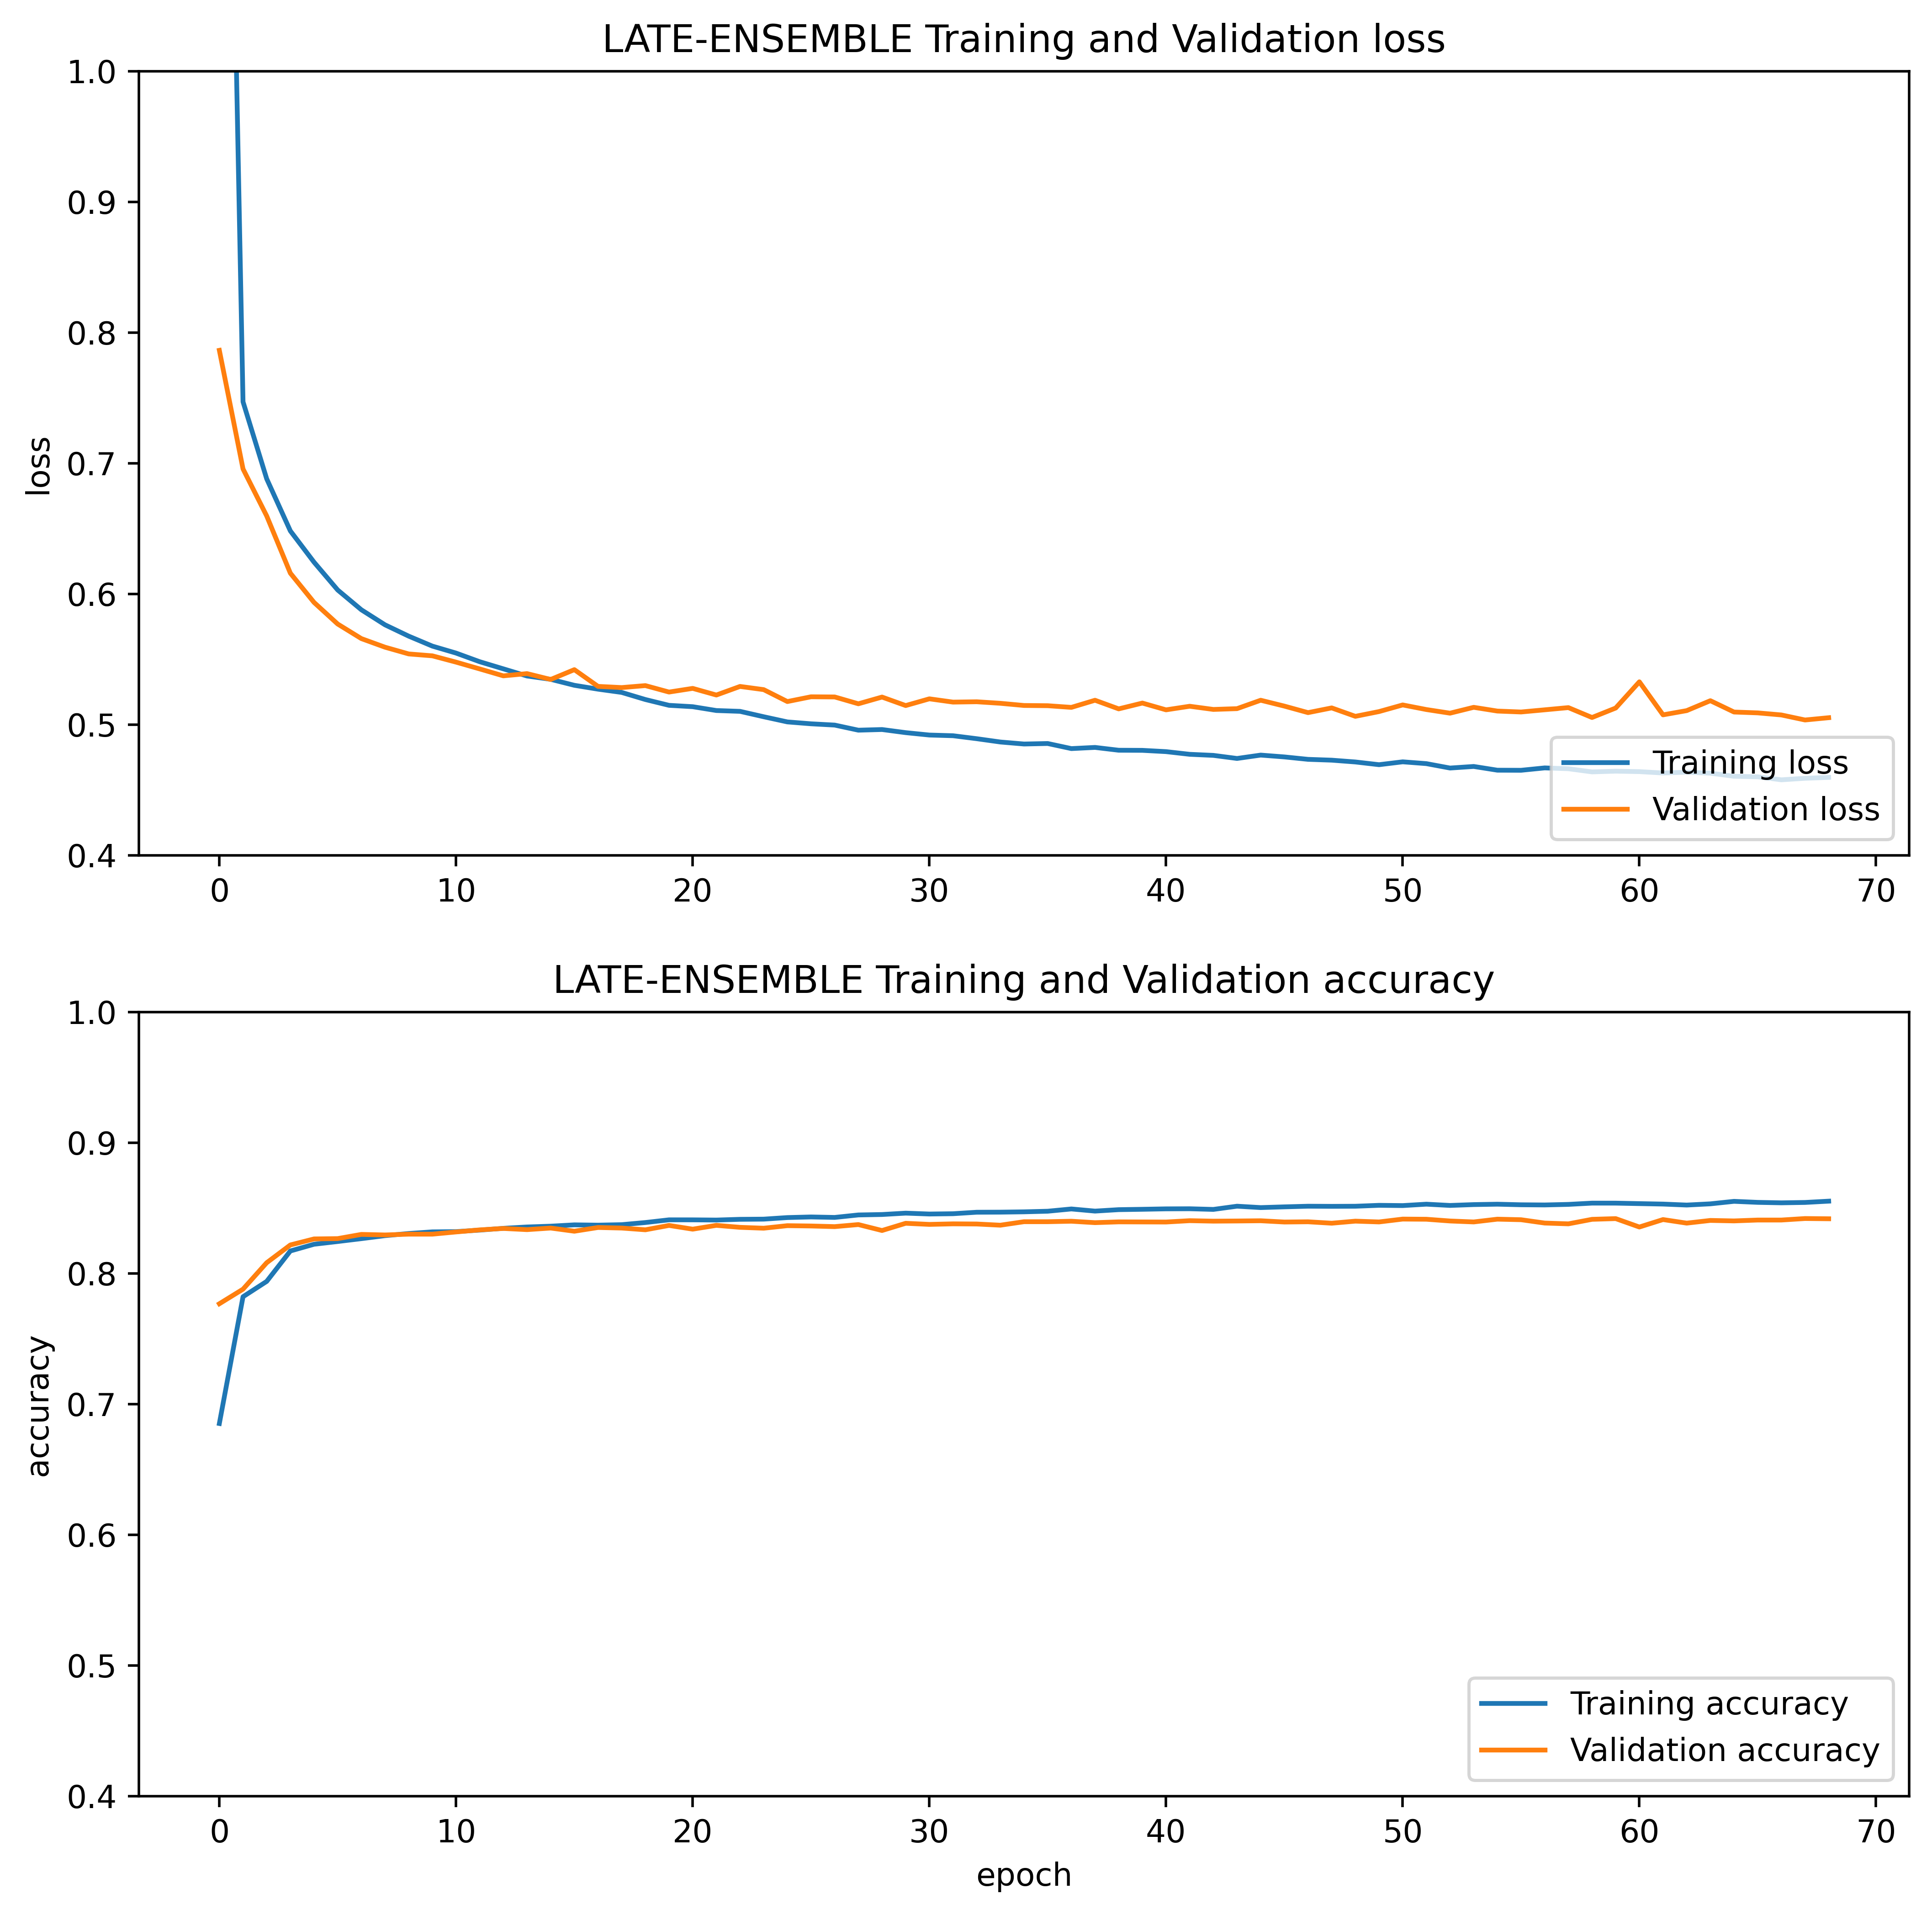

In [31]:
plot_chart(history,name)

In [32]:
y_pred = hypermodel.predict(X_test)

In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [34]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)


for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes

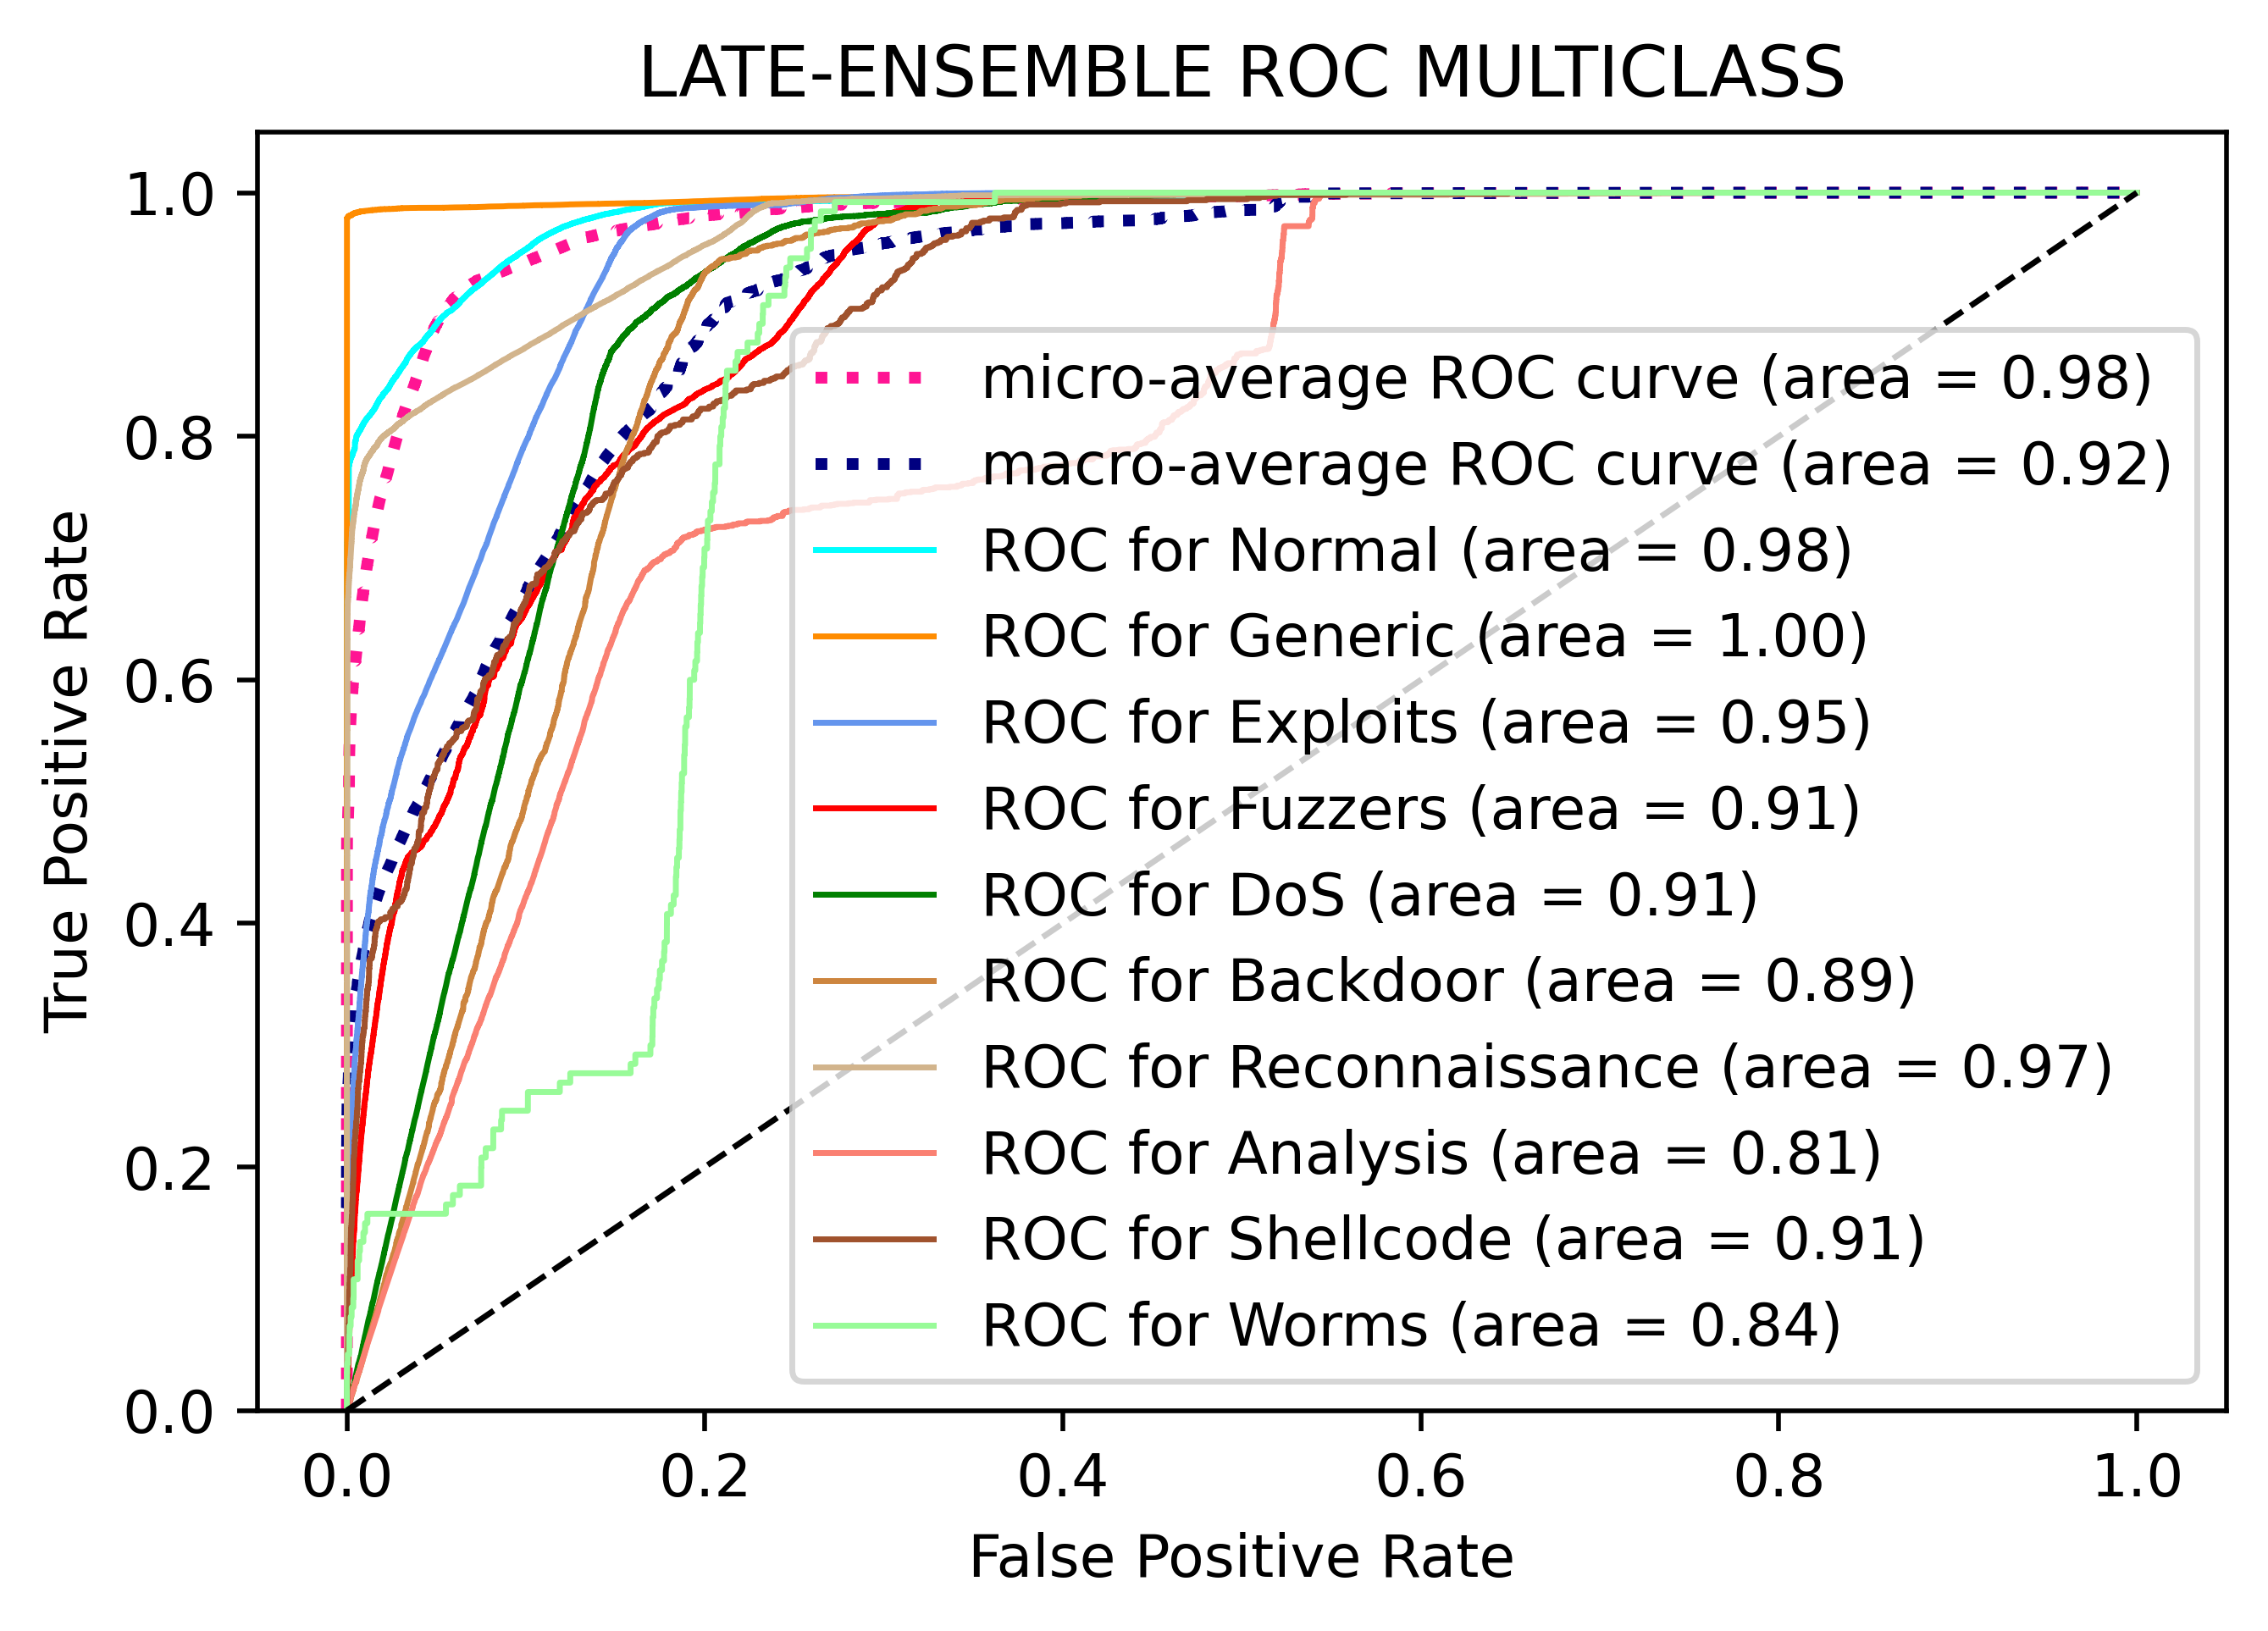

In [35]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=2,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","red","green","peru","tan","salmon","sienna","palegreen"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1,
        label="ROC for {0} (area = {1:0.2f})".format(CLASSES[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LATE-ENSEMBLE ROC MULTICLASS")
plt.legend(loc="lower right")
plt.show()

In [36]:
MODELS_RESULTS

{'LATE-ENSEMBLE': {'train': {'loss': 0.4098561704158783,
   'accuracy': 0.873058557510376,
   'precision': 0.9490966796875,
   'recall': 0.8223487138748169,
   'auc': 0.993427574634552,
   'prc': 0.960639238357544},
  'validation': {'loss': 0.5051853656768799,
   'accuracy': 0.841744065284729,
   'precision': 0.9191082715988159,
   'recall': 0.7886682748794556,
   'auc': 0.9877830147743225,
   'prc': 0.9377472400665283},
  'test': {'loss': 0.6926721334457397,
   'accuracy': 0.7756314873695374,
   'precision': 0.8686501979827881,
   'recall': 0.6974923014640808,
   'auc': 0.97647625207901,
   'prc': 0.8858823180198669}}}

In [37]:
pd.DataFrame(MODELS_RESULTS['LATE-ENSEMBLE'])

,train,validation,test
loss,0.409856,0.505185,0.692672
accuracy,0.873059,0.841744,0.775631
precision,0.949097,0.919108,0.868650
recall,0.822349,0.788668,0.697492
auc,0.993428,0.987783,0.976476
prc,0.960639,0.937747,0.885882
